# Data - How Institutions of Higher Education Can Mine The Key Ingredient of  A Successful Analytics Program

The development of data analytics programs that foster robust decision support systems have become a key component of strategic initiatives for institutions of higher-education. However, college and university leadership teams remain unsure of how to effectively incorporate analytics into the institution's operations.

The object of this project is to explore the power of a predictive system based on the notion that at the end of each semester we can diagnose the chances of a student graduating in 4 years based on all available information up to that point. 

One main objective is to identify an information saturation point upon which actionable intervention is implemented. The hypothesis is that there exists a local maxima saturation point which provides the most appropriate intervention point.

# Tools

In [1]:
# General
from __future__ import print_function, division
import sys

# Database
import cx_Oracle
from sqlalchemy import create_engine
from getpass import getpass

# Tools
import pandas as pd
import seaborn as sns
import random
import string
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
import time
#import pandas_profiling

pd.options.display.max_columns = None

# Analytics
#import pymc3 as pm
from scipy.stats import beta

#IMBALANCED DATA
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#SciKitLearn Models
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier #(wait for scikit release 18.0)
from sklearn.neighbors import KNeighborsClassifier

#XgBoost Model ###################################################################################
# import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
##################################################################################################

#MODEL SELECTION, #EVALUATION METRICS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# Academic Data: Performance & Demographics

#### Grades Data
First we obtain the students grades along with a few variables. The goal is to aggregate the grade records to a semester summary.

In [2]:
username = input('Enter username: ')

password = getpass(prompt='Enter password: ')

Enter username: japitz
Enter password: ········


In [3]:
service_name = 'iraarch'
host = 'ira-oradb01.its.csulb.edu'
port = '1521'
grades_query = 'grd.sql'
dem_query = 'dae.sql'

def db_query(username, password, service_name, host, port, query):

    dsn = cx_Oracle.makedsn(host, port, service_name=service_name)

    cstr = 'oracle://{user}:{password}@{dsn}'.format(
        user=username,
        password=password,
        dsn=dsn
    )

    engine =  create_engine(
        cstr,
        convert_unicode=False,
        pool_recycle=10,
        pool_size=50,
    )

    with open(query, 'r') as f:
        data=f.read()#.replace('\n', '')
        
    return (data, engine)

In [4]:
grades, engine = db_query(username, password, service_name, host, port, grades_query)
grd = pd.read_sql(grades, engine)

demo, engine = db_query(username, password, service_name, host, port, dem_query)
dem = pd.read_sql(demo, engine)


print(grd.shape)
print(dem.shape)

(1048761, 39)
(15802, 24)


In [5]:
grd.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048761 entries, 0 to 1048760
Data columns (total 39 columns):
cohort                     1048761 non-null object
emplid                     1048761 non-null object
term_code                  1048761 non-null object
class_term                 1048761 non-null object
session_code               1048761 non-null object
eot_acad_career            1048761 non-null object
eot_program_cd             1048761 non-null object
eot_program                1048761 non-null object
eot_college_cd             1048528 non-null object
eot_college                1048528 non-null object
eot_department_cd          1048528 non-null object
eot_department             1048528 non-null object
eot_acad_plan_cd           1048761 non-null object
eot_acad_plan              1048761 non-null object
class_college_code         1048384 non-null object
class_college              1048384 non-null object
class_dept_code            1048384 non-null object
class_dept          

In [6]:
dem.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15802 entries, 0 to 15801
Data columns (total 24 columns):
emplid                   15802 non-null object
dem_cohort               15802 non-null object
dem_diff_indx            11480 non-null float64
dae_emplid               15802 non-null object
gender                   15802 non-null object
ethnicity                15802 non-null object
first_generation         15802 non-null object
dep_family_size          15802 non-null object
minority                 15802 non-null object
applicant_family_size    15802 non-null object
applicant_income         15802 non-null object
pelltot_emplid           8975 non-null object
pell_eligibility         8975 non-null object
esa_emplid               15801 non-null object
act_comp                 5396 non-null float64
act_read                 5397 non-null float64
act_math                 5398 non-null float64
act_eng                  5394 non-null float64
act_sci                  5397 non-null float64

In [7]:
#Change 'UNKNOWN' to more unique string to avoid having columns with same name after one-hot-encode

dem['first_generation'] = dem['first_generation'].apply(lambda x: 'First Generation Unknown' if x == 'UNKNOWN' else x)
dem['ethnicity'] = dem['ethnicity'].apply(lambda x: 'ETHNICITY UNKNOWN' if x == 'UNKNOWN' else x)

##### Create Training and Test/Validation Sets of Students at this stage to avoid leakeage 

In [8]:
students = pd.DataFrame(grd['emplid'].unique(), columns=['emplid'])

print('there are {} students'.format(students.shape[0]))

there are 26779 students


##### Create the Grades Trainning and Validation Student Set

In [9]:
students_train, students_dev = train_test_split(students, test_size=0.10, random_state=42)

students_train = pd.DataFrame(students_train)

students_dev = pd.DataFrame(students_dev)

In [10]:
students_train.columns = ['EMPLID']
students_dev.columns = ['EMPLID']

In [11]:
grd[grd['emplid']=='011155428'].sort_values(by=['term_code'])

,cohort,emplid,term_code,class_term,session_code,eot_acad_career,eot_program_cd,eot_program,eot_college_cd,eot_college,eot_department_cd,eot_department,eot_acad_plan_cd,eot_acad_plan,class_college_code,class_college,class_dept_code,class_dept,class_prefix,class_prefix_longdesc,class_catalog_nbr,class_section,class_descr,bcmp,bcmp_units_taken,online_course,units_taken,grading_basis,official_grade,earned_credit,units_attempted,grade_points,status_cd,ge_flag,division,gpa_flag,class_instruction_mode,class_instructor_emplid,home_zip_cd
618220,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,WGSS,Women's Gender Sexuality Stds,WGSS,Women's Gender Sexuality Stds,101,06,Women & Their Bodies,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,001420573,92683
582586,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PSY,Psychology,PSY,Psychology,100,01,General Psychology,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,000003300,92683
515637,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PHIL,Philosophy,PHIL,Philosophy,170,04,Critical Reasoning,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,006822970,92683
640128,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,HIST,History,HIST,History,173,15,Recent United States History,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,005157605,92683
640145,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CHHS,Health and Human Services,KIN,Kinesiology,KIN,Kinesiology,109A,02,Fitness Walking,0,0,Not_Online,1.0,GCR,A,Y,Y,4.0,E,Non_GE,Lower-Division,Include_in_GPA,P,000041481,92683
618249,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,ENGL,English,ENGL,English,100,34,Composition II,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,000040389,92683
616442,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,06,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009460618,92683
598701,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,01,General Organic & Biochemistry,1,5,Not_Online,5.0,GRD,C,Y,Y,10.0,E,GE,Lower-Division,Include_in_GPA,P,000033863,92683
548224,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,MATH,Mathematics,MATH,Mathematics,109,11,Modeling With Algebra,1,3,Not_Online,3.0,GCR,A,Y,Y,12.0,E,GE,Lower-Division,Include_in_GPA,P,008331555,92683
474211,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,13,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009416548,92683


# Preprocessing: One-Hot-Encode Letter Grades

In [12]:
grd.columns = map(str.upper, grd.columns)

In [13]:
grd = pd.concat([grd,pd.get_dummies(grd['OFFICIAL_GRADE'], drop_first=True)], axis=1)

grd.shape

(1048761, 52)

##### Create Variables to Calculate GPA

In [14]:
grd['GRADE_POINTS_IN_GPA'] = grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_IN_GPA'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_FOR_CREDIT'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

#######################################################################################################################

grd['BCMP_GRADE_POINTS_IN_GPA'] = grd['BCMP'] * grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_IN_GPA'] = grd['BCMP_UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_FOR_CREDIT'] = grd['BCMP'] * grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

In [15]:
grd['SUMMER'] = (grd['CLASS_TERM'].apply(lambda x: str(x)[-1]) == '3')* 1 * grd['UNITS_FOR_CREDIT']

grd['WINTER'] = (grd['CLASS_TERM'].apply(lambda x: str(x)[-1]) == '1')* 1 * grd['UNITS_FOR_CREDIT']

##### Reduce the dataframe to variables of current interest

In [16]:
grd = grd.sort_values(by=['EMPLID','TERM_CODE']).copy()[['COHORT', 
                 'EMPLID', 
                 'TERM_CODE',
                 'EOT_ACAD_PLAN_CD',
                 'GRADE_POINTS_IN_GPA',
                 'UNITS_TAKEN',
                 'UNITS_IN_GPA',
                 'UNITS_FOR_CREDIT',
                 'BCMP',
                 'BCMP_GRADE_POINTS_IN_GPA',
                 'BCMP_UNITS_TAKEN',
                 'BCMP_UNITS_IN_GPA',
                 'BCMP_UNITS_FOR_CREDIT',
                 'A', 
                 'AU', 
                 'B',
                 'C', 
                 'CR', 
                 'D', 
                 'F', 
                 'I', 
                 'NC', 
                 'RP', 
                 'W', 
                 'WE', 
                 'WU',
                 'SUMMER',
                 'WINTER']]

##### Aggregate and Reduce from Course Dimension to Term Dimension: Create a cummulative sum of Grade Points and GPA Units:

In [17]:
aggregations = { 'GRADE_POINTS_IN_GPA':'sum',
                 'UNITS_TAKEN':'sum',
                 'UNITS_IN_GPA':'sum',
                 'UNITS_FOR_CREDIT':'sum',
                 'BCMP':'sum',
                 'BCMP_GRADE_POINTS_IN_GPA':'sum',
                 'BCMP_UNITS_TAKEN':'sum',
                 'BCMP_UNITS_IN_GPA':'sum',
                 'BCMP_UNITS_FOR_CREDIT':'sum',
                 'A':'sum', 
                 'AU':'sum', 
                 'B':'sum',
                 'C':'sum', 
                 'CR':'sum', 
                 'D':'sum', 
                 'F':'sum', 
                 'I':'sum', 
                 'NC':'sum', 
                 'RP':'sum', 
                 'W':'sum', 
                 'WE':'sum', 
                 'WU':'sum',
               'SUMMER':'sum',
               'WINTER':'sum'}

grouped_agg = grd.groupby(['COHORT','EMPLID','TERM_CODE','EOT_ACAD_PLAN_CD']).agg(aggregations).reset_index()

In [18]:
grouped_agg.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0


In [19]:
grouped_cumsum = grd[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'GRADE_POINTS_IN_GPA',
                             'UNITS_TAKEN',
                             'UNITS_IN_GPA',
                             'UNITS_FOR_CREDIT',
                             'BCMP',
                             'BCMP_GRADE_POINTS_IN_GPA',
                             'BCMP_UNITS_TAKEN',
                             'BCMP_UNITS_IN_GPA',
                             'BCMP_UNITS_FOR_CREDIT',
                             'SUMMER',
                             'WINTER']].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'COHORT',
                                                 'EOT_ACAD_PLAN_CD',]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grouped_agg,grouped_cumsum],axis=1)

grd.drop(['CUM_EMPLID','CUM_TERM_CODE','CUM_COHORT','CUM_EOT_ACAD_PLAN_CD'],axis=1,inplace=True)

#### Create Term and Cummulative GPA

In [20]:
grd['TERM_GPA'] = grd['GRADE_POINTS_IN_GPA'] / grd['UNITS_IN_GPA']

grd['CUM_GPA'] = grd['CUM_GRADE_POINTS_IN_GPA'] / grd['CUM_UNITS_IN_GPA']

grd['BCMP_TERM_GPA'] = grd['BCMP_GRADE_POINTS_IN_GPA'] / grd['BCMP_UNITS_IN_GPA']

grd['BCMP_CUM_GPA'] = grd['CUM_BCMP_GRADE_POINTS_IN_GPA'] / grd['CUM_BCMP_UNITS_IN_GPA']

##### Check for NaN values since division by 0 is possible:

In [21]:
grd.isnull().sum()

COHORT                               0
EMPLID                               0
TERM_CODE                            0
EOT_ACAD_PLAN_CD                     0
GRADE_POINTS_IN_GPA                  0
UNITS_TAKEN                          0
UNITS_IN_GPA                         0
UNITS_FOR_CREDIT                     0
BCMP                                 0
BCMP_GRADE_POINTS_IN_GPA             0
BCMP_UNITS_TAKEN                     0
BCMP_UNITS_IN_GPA                    0
BCMP_UNITS_FOR_CREDIT                0
A                                    0
AU                                   0
B                                    0
C                                    0
CR                                   0
D                                    0
F                                    0
I                                    0
NC                                   0
RP                                   0
W                                    0
WE                                   0
WU                       

###### Need to deal with NaN values - use imputation

##### impute missing Term and Cum GPA

In this instance it is reasonable to set the Term GPA and CumGPA to zero since NaNs result from Units in GPA and Cum Units in GPA being zero. This means either the student had no Units in GPA for a given term or the Cum Units in GPA was zero since the student failed to pass units in the initial term

In [22]:
grd.fillna(0, inplace=True)

##### Example of students with CumGPA = 0 

In [23]:
grd[grd['CUM_GPA'] == 0].head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
322,2094,004034678,2112,ACCTBS01U1,40.0,17.0,17.0,17.0,0,0.0,0,0.0,0.0,0,0,2,3,0,0,0,0,0,0,0,0,0,0.0,17.0,0.0,3.0,3.0,3.0,1,0.0,3,3.0,3.0,0.0,0.0,2.352941,0.0,0.0,0.0
375,2094,004174025,2114,CE__BS01U1,38.0,11.0,11.0,11.0,2,20.0,5,5.0,5.0,1,0,2,0,0,0,0,0,0,0,0,0,0,0.0,11.0,0.0,8.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,3.454545,0.0,4.0,0.0
560,2094,004878456,2102,MAE_BS02U1,28.0,13.0,9.0,9.0,0,0.0,0,0.0,0.0,1,0,3,0,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,3.111111,0.0,0.0,0.0
561,2094,004878456,2103,MAE_BS02U1,21.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,12.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,0.0,0.0,0.0
702,2094,005017452,2142,HCA_BS01U1,57.0,17.0,17.0,17.0,0,0.0,0,0.0,0.0,3,0,1,2,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,7.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,3.352941,0.0,0.0,0.0


In [24]:
emplid = '011375323'

grd[grd['EMPLID'] == emplid]

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
222618,2124,011375323,2124,NRSGBS02U1,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0,0.0,0.0,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Typically students with CumGPA = 0 fail or withdraw

In [25]:
grd[grd['EMPLID'] == emplid].iloc[0]

COHORT                                2124
EMPLID                           011375323
TERM_CODE                             2124
EOT_ACAD_PLAN_CD                NRSGBS02U1
GRADE_POINTS_IN_GPA                      0
UNITS_TAKEN                              9
UNITS_IN_GPA                             0
UNITS_FOR_CREDIT                         0
BCMP                                     0
BCMP_GRADE_POINTS_IN_GPA                 0
BCMP_UNITS_TAKEN                         0
BCMP_UNITS_IN_GPA                        0
BCMP_UNITS_FOR_CREDIT                    0
A                                        0
AU                                       0
B                                        0
C                                        0
CR                                       0
D                                        0
F                                        0
I                                        0
NC                                       0
RP                                       0
W          

# The Load Index

$L_s = \dfrac{\sum_{i=1}^{k_s} u_i}{U_s}$

$u_i: units\ \ earned \ \ by \ \ taking \ \ class \ \ i.$

$k_s: number \ \ of \ \ classes \ \ taken \ \ in \ \ semester \ \ s.$

$U_s: number \ \ of \ \ units \ \ prescribed \ \ to \ \ be \ \ earned \ \ by \ \ semester \ \ s.$

$The \ \ pattern \ \  of \ \ the \ \ difference \ \  d \ \ 0,7,8,9,10,17,18,19,20,... \ \ $

$Pattern \ \ when \ \ d \ \ mod \ \ 10 \ \ is \ \ 0$    $$N = 2\dfrac{d}{10} + 1 = \dfrac{d}{5} + 1$$

Pattern when d mod 10 is 8    $$N = 2\left(\dfrac{d - 8}{10} + 1\right) = \dfrac{d + 2}{5}$$

In [26]:
grd['TERM_DIFF'] = pd.to_numeric(grd['TERM_CODE']) - pd.to_numeric(grd['COHORT'])
# SEMESTER INDICATOR #
grd['N'] = grd['TERM_DIFF'].apply(lambda x: int(x/5+1) if x%10 == 0 else int((x + 2)/5) )

grd['PRESCRIBED_UNITS'] = grd['N'] * 15

In [27]:
grd['N'].head()

0    0
1    1
2    2
3    3
4    3
Name: N, dtype: int64

In [28]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0,3.000000,3.000000,0.0,0.0,-2,0,0
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.0,0,1,15
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.0,8,2,30
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.0,10,3,45
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.0,17,3,45


In [29]:
grd[['EMPLID','TERM_CODE','N']].head(19)

,EMPLID,TERM_CODE,N
0,000095652,2092,0
1,000095652,2094,1
2,000095652,2102,2
3,000095652,2104,3
4,000095652,2111,3
5,000095652,2112,4
6,000095652,2144,11
7,000095652,2152,12
8,000095652,2154,13
9,000095652,2162,14


In [30]:
grd['LOAD_INDEX'] = grd['CUM_UNITS_FOR_CREDIT'] / grd['PRESCRIBED_UNITS']

grd['COMPLETION_RATE'] = grd['UNITS_FOR_CREDIT'] / grd['UNITS_TAKEN']

## Create The Exclusive Load Index 

In [31]:
grd['UNITS_FOR_CREDIT_EXCLUDE'] = (grd['TERM_DIFF'] >= 0) * grd['UNITS_FOR_CREDIT']

grouped_cumsum = grd[['EMPLID',
                      'TERM_CODE',
                      'COHORT',
                      'UNITS_FOR_CREDIT_EXCLUDE']].groupby(['EMPLID',
                                                                 'TERM_CODE',
                                                                 'COHORT']).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grd,grouped_cumsum],axis=1)

grd['N_EXCLUDE'] = grd['TERM_DIFF'].apply(lambda x: 0 if x < 0 else(int(x/5+1) if int(repr(x)[-1]) == 0 else int((x + 2)/5) ))

grd['PRESCRIBED_UNITS_EXCLUDE'] = grd['N_EXCLUDE'] * 15

grd['LOAD_INDEX_EXCLUDE'] = grd['CUM_UNITS_FOR_CREDIT_EXCLUDE'] / grd['PRESCRIBED_UNITS_EXCLUDE']

In [32]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,CUM_EMPLID,CUM_TERM_CODE,CUM_COHORT,CUM_UNITS_FOR_CREDIT_EXCLUDE,N_EXCLUDE,PRESCRIBED_UNITS_EXCLUDE,LOAD_INDEX_EXCLUDE
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0,3.000000,3.000000,0.0,0.0,-2,0,0,inf,1.0,0.0,000095652,2092,2094,0.0,0,0,NaN
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.0,0,1,15,1.400000,1.0,18.0,000095652,2094,2094,18.0,1,15,1.200000
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.0,8,2,30,1.300000,1.0,18.0,000095652,2102,2094,36.0,2,30,1.200000
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.0,10,3,45,1.177778,1.0,14.0,000095652,2104,2094,50.0,3,45,1.111111
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.0,17,3,45,1.244444,1.0,3.0,000095652,2111,2094,53.0,3,45,1.177778


## Create the Only Prior Load Index Indicator

In [33]:
grd['LOAD_INDEX_ONLY']=grd['LOAD_INDEX']-grd['LOAD_INDEX_EXCLUDE']

grouped_diff = grd[['EMPLID', 'LOAD_INDEX_ONLY']].groupby(['EMPLID']).transform(max).reset_index()

grd = grd.drop(columns='LOAD_INDEX_ONLY')

grd = pd.concat([grd,grouped_diff],axis=1)

In [34]:
grd[['LOAD_INDEX_ONLY','N']].head()

,LOAD_INDEX_ONLY,N
0,0.2,0
1,0.2,1
2,0.2,2
3,0.2,3
4,0.2,3


## Create DFW Variables

In [35]:
grd['DFW'] = grd['D'] + grd['F'] + grd['I'] + grd['NC'] + grd['W'] + grd['WE'] + grd['WU']

grd['DFW_RATE'] = grd['DFW']/grd['UNITS_TAKEN']

## Select Varaibles

In [36]:
grd.drop(labels=['GRADE_POINTS_IN_GPA','UNITS_IN_GPA','BCMP_GRADE_POINTS_IN_GPA',
                'BCMP_UNITS_IN_GPA','CUM_GRADE_POINTS_IN_GPA', 
                'CUM_UNITS_IN_GPA', 'CUM_BCMP_GRADE_POINTS_IN_GPA', 'TERM_DIFF', 
                 'CUM_EMPLID', 'CUM_TERM_CODE', 'CUM_COHORT',
                 'CUM_UNITS_FOR_CREDIT_EXCLUDE', 'N_EXCLUDE', 'PRESCRIBED_UNITS_EXCLUDE', 'index'],axis=1, inplace=True)

## Exclude Rows Before $T_0$

In [37]:
grd = grd[grd['COHORT'] <= grd['TERM_CODE']]

##### The Completion Rate calculation generated a few NaNs

Setting these NaNs to zero is appropriate since they result from dividing by zero (no units taken)

In [38]:
grd.fillna(0, inplace=True)

## Demographic Data

In [39]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP'],
      dtype='object')

### One-Hot-Encode Demographics

In [40]:
dem = pd.concat([dem,
                pd.get_dummies(dem['GENDER'], drop_first=True, prefix='GENDR'),
                pd.get_dummies(dem['ETHNICITY'], drop_first=False),
                pd.get_dummies(dem['FIRST_GENERATION'], drop_first=False),
                pd.get_dummies(dem['DEP_FAMILY_SIZE'], drop_first=False, prefix='DEP_FAM'),
                pd.get_dummies(dem['MINORITY'], drop_first=False, prefix='URM'), 
                pd.get_dummies(dem['APPLICANT_FAMILY_SIZE'], drop_first=False, prefix='APP_FAM'),
                pd.get_dummies(dem['APPLICANT_INCOME'], drop_first=False, prefix='INCM'),
                pd.get_dummies(dem['PELL_ELIGIBILITY'], drop_first=False, prefix='PELL')], axis=1)

In [41]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY'

In [42]:
dem.drop(labels=['GENDER', 'ETHNICITY', 'FIRST_GENERATION',
       'DEP_FAMILY_SIZE', 'MINORITY', 'APPLICANT_FAMILY_SIZE',
       'APPLICANT_INCOME', 'PELL_ELIGIBILITY'], axis=1, inplace=True)

### Create Time to Graduation Response Variables

In [43]:
dem['DEM_N'] = dem['DEM_DIFF_INDX'].apply(lambda x: x if (x >= 0) == False 
                             else int(x/5+1) if (x%10 == 0 or x%10 == 7) 
                             else int((x + 2)/5) )

dem['YRS_TO_GRAD'] = dem['DEM_N'] * 0.5

In [44]:
dem[['DEM_DIFF_INDX','YRS_TO_GRAD']].head(12)

,DEM_DIFF_INDX,YRS_TO_GRAD
0,48.0,5.0
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,48.0,5.0
5,NaN,NaN
6,38.0,4.0
7,NaN,NaN
8,58.0,6.0
9,48.0,5.0


In [45]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'PELLTOT_EMPLID',
       'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI',
       'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
   

In [46]:
dem = pd.concat([dem,pd.get_dummies(dem['YRS_TO_GRAD'], drop_first=False, prefix='GRAD_IN')], axis=1)

In [47]:
dem.drop(labels=['DEM_DIFF_INDX','DEM_N','DAE_EMPLID','PELLTOT_EMPLID','ESA_EMPLID',
                 'YRS_TO_GRAD'], axis=1, inplace=True)

In [48]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_

In [49]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_

### Join the Demographic Data with the CSULB Academic Performance Data

In [50]:
dem = dem.rename(columns={'DEM_COHORT':'COHORT'})

In [51]:
dem.columns

Index(['EMPLID', 'COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_$12,

In [52]:
supreme = pd.merge(dem, grd, on=['EMPLID','COHORT'], how='left')

In [53]:
#pandas_profiling.ProfileReport(supreme)

In [54]:
#pandas_profiling.ProfileReport(supreme).get_rejected_variables()

In [55]:
supreme.drop(labels=[ 'DFW',
                      'AP',
                      'BCMP_UNITS_FOR_CREDIT',
                      'BCMP_UNITS_TAKEN',
                      'CUM_BCMP_UNITS_FOR_CREDIT',
                      'CUM_BCMP_UNITS_IN_GPA',
                      'CUM_BCMP_UNITS_TAKEN',
                      'CUM_UNITS_FOR_CREDIT',
                      'INCM_NO RESPONSE',
                      'UNITS_FOR_CREDIT',
                      'URM_UNKNOWN',
                      'URM_VISA NON U.S.'], axis=1, inplace=True)

In [56]:
pd.options.display.max_seq_items = supreme.columns.shape[0]

supreme.columns

Index(['EMPLID', 'COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4',
       'APP_FAM_5', 'APP_FAM_6', 'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
     

### ACT, SAT and HS GPA Scores Preprocessing

Students may have ACT or SAT or both scores. The idea is to create a feature that would capture test performance in a general sense. The approach use here is to create three features that capture performance in Math, Reading and Composite performance. To this end we scale and center both ACT and SAT test scores in math, reading and composite and, in the event a student has taken both,choose the maximum normalized score.

##### Need to impute missing values of ACT and SAT scores:

Before this preprocessing step is undertaken it is necessary to split the student data into trainning and development sets in order to avoid "leakeage" from trainning into development since the imputing calculations and methods use the entire dataset.

In [57]:
supreme['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

In [58]:
supreme_train = pd.merge(students_train, supreme, on='EMPLID', how='inner')
print(supreme_train.shape)

supreme_dev = pd.merge(students_dev, supreme, on='EMPLID', how='inner')
print(supreme_dev.shape)

(135458, 113)
(15215, 113)


In [59]:
supreme_train.isnull().sum().head(55)

EMPLID                                       0
COHORT                                       0
ACT_COMP                                 89131
ACT_READ                                 89125
ACT_MATH                                 89115
ACT_ENG                                  89157
ACT_SCI                                  89125
SAT_READ                                  6402
SAT_MATH                                  6402
SAT_COMP                                  6402
GPA_HS                                     510
GENDR_M                                      0
AFRICAN AMERICAN                             0
ASIAN AMERICAN                               0
CAUCASIAN                                    0
ETHNICITY UNKNOWN                            0
LATINO/LATINA                                0
NATIVE AMERICAN                              0
PACIFIC ISLANDER                             0
TWO OR MORE RACES, INCLUDING MINORITY        0
TWO OR MORE RACES, NON-MINORITIES            0
VISA NON U.S.

In [60]:
supreme_train.iloc[:,44:57].columns

Index(['APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5',
       'APP_FAM_6', 'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
       'INCM_$36,000 TO $47,999'],
      dtype='object')

In [61]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP', 'GPA_HS']].head()

,ACT_COMP,ACT_READ,ACT_MATH,ACT_ENG,ACT_SCI,SAT_READ,SAT_MATH,SAT_COMP,GPA_HS
0,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
1,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
2,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
3,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
4,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0


In [62]:
supreme_train['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

##### Scale the scores and choose the max

In [63]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [64]:
supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [65]:
print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].mean()
)

print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].std()
)

ACT_COMP    1.197887e-15
ACT_READ   -4.812654e-16
ACT_MATH   -1.169149e-15
ACT_ENG    -3.162317e-16
ACT_SCI    -1.896650e-15
SAT_READ    7.892170e-16
SAT_MATH    7.023611e-16
SAT_COMP   -5.803826e-16
dtype: float64
ACT_COMP    1.000011
ACT_READ    1.000011
ACT_MATH    1.000011
ACT_ENG     1.000011
ACT_SCI     1.000011
SAT_READ    1.000004
SAT_MATH    1.000004
SAT_COMP    1.000004
dtype: float64


In [66]:
supreme_train['T_COMP'] = supreme_train[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_train['T_READ'] = supreme_train[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_train['T_MATH'] = supreme_train[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [67]:
supreme_dev['T_COMP'] = supreme_dev[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_READ'] = supreme_dev[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_MATH'] = supreme_dev[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [68]:
supreme_train[['T_COMP','T_READ','T_MATH']].isnull().sum()

T_COMP    1395
T_READ    1395
T_MATH    1395
dtype: int64

##### For now impute values by using the mean

In [69]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [70]:
test_scores = supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

In [71]:
test_scores = supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

##### Drop unecessary features

In [72]:
supreme_train['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

In [73]:
supreme_train.columns[30:50]

Index(['DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3',
       'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8',
       'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY',
       'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5',
       'APP_FAM_6'],
      dtype='object')

In [74]:
supreme_train.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

supreme_dev.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

##### The AP feature is null - impute with a constant for now

In [75]:
supreme_train['AP'] = 0

supreme_dev['AP'] = 0

In [76]:
supreme_train.isnull().sum().head(55)

EMPLID                                   0
COHORT                                   0
GPA_HS                                   0
GENDR_M                                  0
AFRICAN AMERICAN                         0
ASIAN AMERICAN                           0
CAUCASIAN                                0
ETHNICITY UNKNOWN                        0
LATINO/LATINA                            0
NATIVE AMERICAN                          0
PACIFIC ISLANDER                         0
TWO OR MORE RACES, INCLUDING MINORITY    0
TWO OR MORE RACES, NON-MINORITIES        0
VISA NON U.S.                            0
CONTINUING GENERATION STUDENT            0
FIRST GENERATION STUDENT                 0
FIRST GENERATION UNKNOWN                 0
DEP_FAM_1                                0
DEP_FAM_10                               0
DEP_FAM_11                               0
DEP_FAM_12                               0
DEP_FAM_13                               0
DEP_FAM_14                               0
DEP_FAM_15 

### Create the Major Plan Change Index

##### Academic plans are 10 characters in length

In [77]:
supreme_train['EOT_ACAD_PLAN_CD']

0         BIOLPR07U1
1         SW__PR00U1
2         SW__PR00U1
3         SOC_PR00U1
4         SOC_BA01U1
5         SOC_BA01U1
6         SOC_BA01U1
7         SOC_BA01U1
8         SOC_BA01U1
9         SOC_BA01U1
10        ART_PR01U1
11        ART_PR01U1
12        ART_PR01U1
13        RGR_BA03U1
14        RGR_BA03U1
15        RGR_BA03U1
16        RGR_BA03U1
17        RGR_BA03U1
18        RGR_BA03U1
19        RGR_BA03U1
20        RGR_BA03U1
21        RGR_BA03U1
22        RGR_BA03U1
23        EDSSCS69C1
24        EDSSCS69C1
25        EDSSCS69C1
26        ECONBA01U1
27        MATHBS01U1
28        MATHBS01U1
29        MATHBS01U1
             ...    
135428    MAE_BS04U1
135429    MAE_BS04U1
135430    NDUGOT00U1
135431    NDUGOT00U1
135432    NDUGOT00U1
135433    CE__BS01U1
135434    CE__BS01U1
135435    CE__BS01U1
135436    CE__BS01U1
135437    PSY_BA01U1
135438    PSY_BA01U1
135439    PSY_BA01U1
135440    ENGLBA01U1
135441    ENGLBA01U1
135442    HSC_BS02U1
135443    HSC_BS02U1
135444    HSC

In [78]:
supreme_train['EOT_ACAD_PLAN_CD'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: str(x))
supreme_dev['EOT_ACAD_PLAN_CD'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: str(x))

In [79]:
supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: len(x)).describe()

count    135458.000000
mean          9.999948
std           0.019019
min           3.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: EOT_ACAD_PLAN_CD, dtype: float64

##### The first 4 characters representthe department/subject. The 5th and 6th character encode the plan type and allows to separate pre-majors from majors. A change from pre-major to major in the same department/subject is not considered a major change.

In [80]:
print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6]).head()
)

print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4]).head()
)

0    PR
1    PR
2    PR
3    PR
4    BA
Name: EOT_ACAD_PLAN_CD, dtype: object
0    BIOL
1    SW__
2    SW__
3    SOC_
4    SOC_
Name: EOT_ACAD_PLAN_CD, dtype: object


##### Create codes

In [81]:
supreme_train['SUBJECT'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_train['PLAN_TYPE'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [82]:
supreme_dev['SUBJECT'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_dev['PLAN_TYPE'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [83]:
supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].head()

,EMPLID,SUBJECT,PLAN_TYPE
0,010705940,BIOL,PR
1,010705940,SW__,PR
2,010705940,SW__,PR
3,010705940,SOC_,PR
4,010705940,SOC_,BA


##### Create Major Change indicator

In [84]:
supreme_train['MAJOR_CHANGE_INDICATOR'] = ( supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)

In [85]:
supreme_dev['MAJOR_CHANGE_INDICATOR'] = ( supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)


##### Create a cumulative Major Change Counter

In [86]:
grouped_cumsum = supreme_train[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_train = pd.concat([supreme_train,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_train.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

In [87]:
grouped_cumsum = supreme_dev[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_dev = pd.concat([supreme_dev,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_dev.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

##### Rearrange features

In [88]:
supreme_train.columns

Index(['EMPLID', 'COHORT', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN', 'LATINO/LATINA',
       'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4',
       'APP_FAM_5', 'APP_FAM_6', 'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
       'INCM_$36,000 TO $47,999', 'INCM_$48,000 TO $59,999',
       'INCM_$6,000 TO $11,999', 'INCM_$60,00

In [89]:
id_var = ['COHORT', 'EMPLID']

perf_var = ['TERM_CODE', 'SEMESTER_INDEX', 'EOT_ACAD_PLAN_CD', 'MAJOR_CHANGE_INDICATOR','MAJOR_CHANGE_CNT',
            'UNITS_TAKEN','BCMP', 'A', 'AU', 'B' ,'C','CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER', 
            'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA','CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA',
            'COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY','DFW_RATE','T_COMP', 'T_READ','T_MATH']

dem_var = ['GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN','ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 
           'NATIVE AMERICAN','PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
           'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.','CONTINUING GENERATION STUDENT', 
           'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN','DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
           'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6','DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 
           'DEP_FAM_NA', 'URM_MINORITY','URM_NON-MINORITY', 'APP_FAM_1',
           'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA','INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
           'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL', 
           'PELL_TRADITIONAL']

resp_var = ['GRAD_IN_2.5','GRAD_IN_3.0', 'GRAD_IN_3.5', 'GRAD_IN_4.0', 'GRAD_IN_4.5','GRAD_IN_5.0', 'GRAD_IN_5.5', 
          'GRAD_IN_6.0']

In [90]:
supreme_train = supreme_train[id_var + perf_var + dem_var + resp_var]
supreme_dev = supreme_dev[id_var + perf_var + dem_var + resp_var]

In [91]:
for feature in supreme_train.columns: print(feature)

COHORT
EMPLID
TERM_CODE
SEMESTER_INDEX
EOT_ACAD_PLAN_CD
MAJOR_CHANGE_INDICATOR
MAJOR_CHANGE_CNT
UNITS_TAKEN
BCMP
A
AU
B
C
CR
D
F
I
NC
RP
W
WE
WU
SUMMER
CUM_BCMP
CUM_SUMMER
CUM_WINTER
TERM_GPA
CUM_GPA
BCMP_TERM_GPA
BCMP_CUM_GPA
COMPLETION_RATE
LOAD_INDEX_EXCLUDE
LOAD_INDEX_ONLY
DFW_RATE
T_COMP
T_READ
T_MATH
GPA_HS
GENDR_M
AFRICAN AMERICAN
ASIAN AMERICAN
CAUCASIAN
LATINO/LATINA
NATIVE AMERICAN
PACIFIC ISLANDER
TWO OR MORE RACES, INCLUDING MINORITY
TWO OR MORE RACES, NON-MINORITIES
ETHNICITY UNKNOWN
VISA NON U.S.
CONTINUING GENERATION STUDENT
FIRST GENERATION STUDENT
FIRST GENERATION UNKNOWN
DEP_FAM_1
DEP_FAM_10
DEP_FAM_12
DEP_FAM_15
DEP_FAM_2
DEP_FAM_25
DEP_FAM_3
DEP_FAM_4
DEP_FAM_5
DEP_FAM_6
DEP_FAM_7
DEP_FAM_8
DEP_FAM_9
DEP_FAM_NA
URM_MINORITY
URM_NON-MINORITY
APP_FAM_1
APP_FAM_2
APP_FAM_3
APP_FAM_6
APP_FAM_NA
INCM_$12,000 TO $23,999
INCM_$6,000 TO $11,999
INCM_$60,000 OR MORE
INCM_LESS THEN $6000
PELL_NON TRADITIONAL
PELL_TRADITIONAL
GRAD_IN_2.5
GRAD_IN_3.0
GRAD_IN_3.5
GRAD_IN_4.0
GRA

In [92]:
supreme_train[['SUMMER','CUM_SUMMER','CUM_WINTER']].head(9)

,SUMMER,CUM_SUMMER,CUM_WINTER
0,0.0,0.0,0.0
1,12.0,12.0,0.0
2,12.0,24.0,0.0
3,0.0,24.0,0.0
4,0.0,24.0,0.0
5,0.0,24.0,0.0
6,0.0,24.0,0.0
7,0.0,24.0,0.0
8,0.0,24.0,0.0


In [93]:
supreme_train[supreme_train['EMPLID'] == '011193375']

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
25644,2124,011193375,2124,1.0,CBA_PR01U1,0,0.0,13.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.384615,1.384615,0.0,0.0,1.0,0.866667,0.0,0.076923,-0.411661,-0.24588,-0.479698,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
25645,2124,011193375,2132,2.0,CBA_PR01U1,0,0.0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,12.0,0.0,1.500000,1.440000,0.0,0.0,1.0,0.833333,0.0,0.166667,-0.411661,-0.24588,-0.479698,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Descripte Stats

In [94]:
supreme_train['GPA_HS'].describe()

count    135458.000000
mean        343.886327
std          37.431058
min         122.000000
25%         317.000000
50%         345.000000
75%         371.000000
max         442.000000
Name: GPA_HS, dtype: float64

In [95]:
pd.to_numeric(supreme['TERM_CODE']).describe()

count    150672.000000
mean       2134.661921
std          20.286647
min        2094.000000
25%        2122.000000
50%        2134.000000
75%        2152.000000
max        2192.000000
Name: TERM_CODE, dtype: float64

### Define Sequential Data Chunks

In [96]:
# Clean up semester_index as to eliminate floats
print(supreme_train['SEMESTER_INDEX'].unique())
supreme_train.dropna(inplace=True)
supreme_train['SEMESTER_INDEX'] = supreme_train['SEMESTER_INDEX'].astype('int32')

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. nan]


In [97]:
#Change to numeric type
supreme_train['TERM_CODE'] = pd.to_numeric(supreme_train['TERM_CODE'])
supreme_dev['TERM_CODE'] = pd.to_numeric(supreme_dev['TERM_CODE'])

In [98]:
supreme_train[supreme_train['EMPLID'] == '010841881'][['EMPLID', 'SEMESTER_INDEX', 'TERM_GPA']].head()

,EMPLID,SEMESTER_INDEX,TERM_GPA
116584,010841881,1,1.8750
116585,010841881,2,2.0000
116586,010841881,3,2.2500
116587,010841881,4,2.6000
116588,010841881,5,2.8125


In [170]:
seq = {'TRAIN0':supreme_train[id_var + dem_var + resp_var]}
seq['DEV0'] = supreme_dev[id_var + dem_var + resp_var]

seq['TRAIN0'].drop_duplicates(inplace=True)

seq['DEV0'].drop_duplicates(inplace=True)

/localhome/exx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/localhome/exx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [171]:
for s in supreme_train['SEMESTER_INDEX'].unique():
    seq['TRAIN{}'.format(s)] = supreme_train[supreme_train['SEMESTER_INDEX'] <= s]
    seq['DEV{}'.format(s)] = supreme_dev[supreme_dev['SEMESTER_INDEX'] <= s]

In [172]:
seq.keys()

dict_keys(['TRAIN0', 'DEV0', 'TRAIN1', 'DEV1', 'TRAIN2', 'DEV2', 'TRAIN3', 'DEV3', 'TRAIN4', 'DEV4', 'TRAIN5', 'DEV5', 'TRAIN6', 'DEV6', 'TRAIN7', 'DEV7', 'TRAIN8', 'DEV8', 'TRAIN9', 'DEV9', 'TRAIN10', 'DEV10', 'TRAIN11', 'DEV11', 'TRAIN12', 'DEV12', 'TRAIN13', 'DEV13', 'TRAIN14', 'DEV14', 'TRAIN15', 'DEV15', 'TRAIN16', 'DEV16', 'TRAIN17', 'DEV17', 'TRAIN18', 'DEV18', 'TRAIN19', 'DEV19', 'TRAIN20', 'DEV20'])

In [173]:
print(seq['TRAIN0'].shape)
print(seq['TRAIN1'].shape)
print(seq['TRAIN2'].shape)
print(seq['TRAIN3'].shape)

(14195, 52)
(14466, 87)
(29802, 87)
(42715, 87)


In [174]:
print(seq['TRAIN0']['GRAD_IN_4.0'].mean())

0.14413525889397674


In [175]:
# supreme_dev.to_csv('supreme_dev.csv')

# supreme_train.to_csv('supreme_train.csv')

# Modelling

In [176]:
def model_tuner(X_train,y_train,X_dev,y_dev,model,grid = None):
    
    if grid == None:
        clf = model
    else:
        clf = GridSearchCV(model, grid, cv=10, n_jobs = -1)
    
    clf_fit = clf.fit(X_train,y_train)
    
    if grid != None: 
        best_par = clf.best_params_
    
    y_dev_pred = clf.predict(X_dev)
    y_train_pred = clf.predict(X_train)
    p_pred = clf.predict(X_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    if grid != None: 
        print ('\nthe optimal parameters are: {}'.format(best_par))
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n{}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    if grid != None:
        results_dict = {'best model':clf_fit,'best parameters':best_par, 'predicted dev values':y_dev_pred, 
                        'predicted training values':y_train_pred,'predicted probabilities':p_pred,
                        'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    else:
        results_dict = {'best model':clf_fit, 'predicted dev values':y_dev_pred, 'predicted training values':y_train_pred, 
                        'predicted probabilities':p_pred,'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    return results_dict

In [177]:
var = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER','TERM_GPA','BCMP_TERM_GPA','COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 
       'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS','GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER', 
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN',
       'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 
       'PELL_NON TRADITIONAL', 'PELL_TRADITIONAL', 'T_COMP', 'T_READ',
       'T_MATH'
    
]


var2 = [
    
       'MAJOR_CHANGE_CNT', 'A', 'AU', 'B',
       'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

var3 = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

In [251]:
t=0
time_to_grad=4

train_t = 'TRAIN{}'.format(str(t))
dev_t = 'DEV{}'.format(str(t))
response = 'GRAD_IN_{}.0'.format(time_to_grad)

y_train = seq[train_t][response]
y_train.head()

0     0
10    0
13    0
26    0
27    0
Name: GRAD_IN_4.0, dtype: uint8

In [252]:
y_dev = seq[dev_t][['COHORT','EMPLID',response]]
y_dev.head()

,COHORT,EMPLID,GRAD_IN_4.0
0,2124,010756523,0
12,2104,008872524,0
23,2094,008028811,0
34,2114,009849500,0
38,2094,007965462,0


In [253]:
X_train = seq[train_t][dem_var]
X_train.head()

,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL
0,336.000000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
10,311.000000,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
13,342.000000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
26,343.886327,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
27,292.000000,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [254]:
train_col = X_train.columns

In [255]:
X_dev = seq[dev_t][dem_var]
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)

X_train

array([[3.36000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.11000000e+02, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.42000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [3.50000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.22050183e-02],
       [3.23000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.61576658e-01],
       [4.17420224e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [257]:
pd.DataFrame(data=X_train,columns=train_col).head()

,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL
0,336.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,311.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,342.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,343.886327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,292.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [258]:
def seq_data(t, time_to_grad, features):
    train_t = 'TRAIN{}'.format(str(t))
    dev_t = 'DEV{}'.format(str(t))
    response = 'GRAD_IN_{}.0'.format(time_to_grad)

    y_train = seq[train_t][response]
    y_dev = seq[dev_t][response]
    X_train = seq[train_t][features]
    X_dev = seq[dev_t][features]

    X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    X_train = pd.DataFrame(data=X_train,columns=features)
    #X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)
    
    return (X_train,y_train,X_dev,y_dev)

In [259]:
def accuracy_matrix_fn(df, data):
    aMat = df
    aMat = aMat.append(pd.DataFrame(data), sort=False)
    aMat.reset_index(inplace=True,drop=True)
    return aMat

In [260]:
def run_model(model,grid = None,label=None):
    start = time.time()
    results_log = model_tuner(X_train,y_train,X_dev,y_dev,model,grid)
    end = time.time()
    runtime = end - start
    print ('the runtime is {} minutes'.format(runtime/60))
    
    return {'model':label,'dev accuracy':[results_log['dev accuracy']], 'training accuracy':[results_log['training accuracy']]}

In [261]:
random_state = 42

##### Logistic at $t_0$

In [262]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

In [263]:
log_mod = LogisticRegression(solver='lbfgs', max_iter=10000, random_state = random_state)

In [264]:
t0_log_accuracy = run_model(model=log_mod,label='logistic @ t0')


accuracy on the dev set is: 0.6357409713574097

accuracy on the train set is: 0.6358959585151042

confusion matrix:

[[878 502]
 [ 83 143]]

classification report:

              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1380
           1       0.22      0.63      0.33       226

    accuracy                           0.64      1606
   macro avg       0.57      0.63      0.54      1606
weighted avg       0.82      0.64      0.69      1606

the runtime is 0.004360564549763997 minutes


In [265]:
accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_log_accuracy), sort=False)

In [266]:
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.635741,0.635896


##### Logistic at $t_1$

In [205]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

t1_log_accuracy = run_model(model=log_mod,label='logistic @ t1')


accuracy on the dev set is: 0.6430750457596095

accuracy on the train set is: 0.686362533365688

confusion matrix:

[[882 526]
 [ 59 172]]

classification report:

              precision    recall  f1-score   support

           0       0.94      0.63      0.75      1408
           1       0.25      0.74      0.37       231

    accuracy                           0.64      1639
   macro avg       0.59      0.69      0.56      1639
weighted avg       0.84      0.64      0.70      1639

the runtime is 0.03903133471806844 minutes


In [206]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.636364,0.643469
1,logistic @ t1,0.643075,0.686363


##### Logistic at $t_2$

In [207]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
t2_log_accuracy = run_model(model=log_mod,label='logistic @ t2')


accuracy on the dev set is: 0.6442652329749103

accuracy on the train set is: 0.6910554702570765

confusion matrix:

[[1793 1067]
 [ 124  364]]

classification report:

              precision    recall  f1-score   support

           0       0.94      0.63      0.75      2860
           1       0.25      0.75      0.38       488

    accuracy                           0.64      3348
   macro avg       0.59      0.69      0.57      3348
weighted avg       0.84      0.64      0.70      3348

the runtime is 0.08180955648422242 minutes


In [208]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.636364,0.643469
1,logistic @ t1,0.643075,0.686363
2,logistic @ t2,0.644265,0.691055


##### Logistic at $t_3$

In [209]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
t3_log_accuracy = run_model(model=log_mod,label='logistic @ t3')


accuracy on the dev set is: 0.6517931609674729

accuracy on the train set is: 0.690510404288833

confusion matrix:

[[2594 1481]
 [ 189  532]]

classification report:

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      4075
           1       0.26      0.74      0.39       721

    accuracy                           0.65      4796
   macro avg       0.60      0.69      0.57      4796
weighted avg       0.83      0.65      0.70      4796

the runtime is 0.1482352574666341 minutes


In [210]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.636364,0.643469
1,logistic @ t1,0.643075,0.686363
2,logistic @ t2,0.644265,0.691055
3,logistic @ t3,0.651793,0.690510


##### Logistic at $t_4$

In [211]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
t4_log_accuracy = run_model(model=log_mod,label='logistic @ t4')


accuracy on the dev set is: 0.6539672544080605

accuracy on the train set is: 0.6929183467741935

confusion matrix:

[[3428 1933]
 [ 265  726]]

classification report:

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      5361
           1       0.27      0.73      0.40       991

    accuracy                           0.65      6352
   macro avg       0.60      0.69      0.58      6352
weighted avg       0.83      0.65      0.70      6352

the runtime is 0.2405611276626587 minutes


In [212]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t4_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.636364,0.643469
1,logistic @ t1,0.643075,0.686363
2,logistic @ t2,0.644265,0.691055
3,logistic @ t3,0.651793,0.690510
4,logistic @ t4,0.653967,0.692918


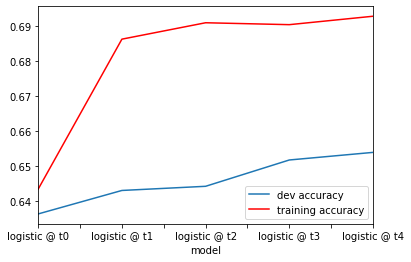

In [213]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### Random Forest 

##### Random Forest @ $t_0$

In [192]:
# X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

# parameters_rf = {'n_estimators':[100,100],'max_features':[1,int(np.sqrt(len(dem_var)))]}
# rf = RandomForestClassifier(n_jobs=-1, random_state = random_state)

# t0_rf_accuracy = run_model(model=rf,grid=parameters_rf,label='random forest @ t0')

# accuracy_matrix = pd.DataFrame()
# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix


the optimal parameters are: {'max_features': 6, 'n_estimators': 100}

accuracy on the dev set is: 0.6028476219327477

accuracy on the train set is: 0.9735434510308406

confusion matrix:

[[2882  419]
 [2203 1098]]

classification report:

              precision    recall  f1-score   support

           0       0.57      0.87      0.69      3301
           1       0.72      0.33      0.46      3301

    accuracy                           0.60      6602
   macro avg       0.65      0.60      0.57      6602
weighted avg       0.65      0.60      0.57      6602

the runtime is 0.23561349312464397 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.602848,0.973543


##### Random Forest @ $t_1$

In [198]:
# X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

# parameters_rf = {'n_estimators':[5,5],'max_features':[7,int(np.sqrt(len(var)))]}

# t1_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t1')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix


the optimal parameters are: {'max_features': 7, 'n_estimators': 5}

accuracy on the dev set is: 0.8266129032258065

accuracy on the train set is: 0.9875112849834486

confusion matrix:

[[331  41]
 [ 88 284]]

classification report:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       372
           1       0.87      0.76      0.81       372

    accuracy                           0.83       744
   macro avg       0.83      0.83      0.83       744
weighted avg       0.83      0.83      0.83       744

the runtime is 0.019202454884847005 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.602848,0.973543
1,random forest @ t1,0.856183,1.000000
2,random forest @ t1,0.877688,1.000000
3,random forest @ t1,0.856183,0.993981
4,random forest @ t1,0.826613,0.987511


##### Random Forest @ $t_2$

In [181]:
# X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

# t2_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t2')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix


the optimal parameters are: {'max_features': 40, 'n_estimators': 50}

accuracy on the dev set is: 0.849933598937583

accuracy on the train set is: 0.9998533079067038

confusion matrix:

[[711  42]
 [184 569]]

classification report:

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       753
           1       0.93      0.76      0.83       753

    accuracy                           0.85      1506
   macro avg       0.86      0.85      0.85      1506
weighted avg       0.86      0.85      0.85      1506

the runtime is 0.15364168882369994 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.559679,0.974085
1,random forest @ t1,0.861559,0.999549
2,random forest @ t2,0.849934,0.999853


##### Random Forest @ $t_3$

In [182]:
# X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

# t3_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t3')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix


the optimal parameters are: {'max_features': 40, 'n_estimators': 50}

accuracy on the dev set is: 0.8159366262814539

accuracy on the train set is: 1.0

confusion matrix:

[[1012   61]
 [ 334  739]]

classification report:

              precision    recall  f1-score   support

           0       0.75      0.94      0.84      1073
           1       0.92      0.69      0.79      1073

    accuracy                           0.82      2146
   macro avg       0.84      0.82      0.81      2146
weighted avg       0.84      0.82      0.81      2146

the runtime is 0.231103777885437 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.559679,0.974085
1,random forest @ t1,0.861559,0.999549
2,random forest @ t2,0.849934,0.999853
3,random forest @ t3,0.815937,1.000000


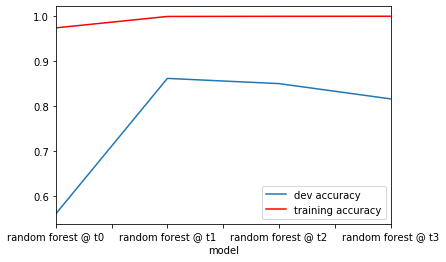

In [183]:
# ax = plt.gca()

# accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
# accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

# plt.show()

### XGBoost

##### XGBoost @ $t_0$

In [267]:
def run_model_xgb(label,num_round):
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_dev = xgb.DMatrix(X_dev, label=y_dev)
    
    param = {'max_depth': 6, 'eta': 0.6, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(d_dev, 'eval'), (d_train, 'train')]

    bst = xgb.train(param, d_train, num_round, evallist, verbose_eval=True)
    
    y_dev_pred = (bst.predict(d_dev) > 0.5) * 1
    y_train_pred = (bst.predict(d_train) > 0.5) * 1
    p_pred = bst.predict(d_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    dev_f1 = f1_score(y_dev,y_dev_pred)
    train_f1 = f1_score(y_train,y_train_pred)
    dev_precision = precision_score(y_dev,y_dev_pred)
    train_precision = precision_score(y_train,y_train_pred)
    dev_recall = recall_score(y_dev,y_dev_pred)
    train_recall = recall_score(y_train,y_train_pred)
    dev_roc = roc_auc_score(y_dev,y_dev_pred)
    train_roc = roc_auc_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n {}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    metrics = {'model':label,
               'dev accuracy':[dev_accuracy], 
               'training accuracy':[train_accuracy],
               'dev f1':[dev_f1],
               'training f1':[train_f1],
               'dev precision':[dev_precision],
               'training precision':[train_precision],
               'dev recall':[dev_recall],
               'training recall':[train_recall],
               'dev roc':[dev_roc],
               'training roc':[train_roc]
              } 
    
    predict = {'predicted dev values':[y_dev_pred],
               'predicted training values':[y_train_pred],
               'predicted probabilities':[p_pred],
               'confusion matrix':[cm],
               'classification report':[report]}
    
    return (metrics, predict)

In [291]:
epochs = 14

In [292]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)
metrics,_ = run_model_xgb('xgb@t0',epochs)

[0]	eval-auc:0.647183	train-auc:0.853019
[1]	eval-auc:0.659664	train-auc:0.898114
[2]	eval-auc:0.655773	train-auc:0.91477
[3]	eval-auc:0.65729	train-auc:0.922011
[4]	eval-auc:0.654444	train-auc:0.927481
[5]	eval-auc:0.659504	train-auc:0.932033
[6]	eval-auc:0.665602	train-auc:0.934627
[7]	eval-auc:0.661182	train-auc:0.936437
[8]	eval-auc:0.657309	train-auc:0.93756
[9]	eval-auc:0.657702	train-auc:0.939245
[10]	eval-auc:0.659048	train-auc:0.94025
[11]	eval-auc:0.659922	train-auc:0.941042
[12]	eval-auc:0.658931	train-auc:0.942391
[13]	eval-auc:0.655969	train-auc:0.94338

accuracy on the dev set is: 0.8393524283935243

accuracy on the train set is: 0.8835706642522019

confusion matrix:

 [[1322   58]
 [ 200   26]]

classification report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1380
           1       0.31      0.12      0.17       226

    accuracy                           0.84      1606
   macro avg       0.59      0.54     

/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [293]:
acc_mat = accuracy_matrix_fn(pd.DataFrame(), metrics)
acc_mat

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.839352,0.883571,0.167742,0.873824,0.309524,0.95366,0.115044,0.806322,0.536508,0.883571


##### XGBoost @ $t_1$

In [294]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

metrics,_ = run_model_xgb('xgb@t1',epochs)

[0]	eval-auc:0.690053	train-auc:0.884275
[1]	eval-auc:0.726197	train-auc:0.919504
[2]	eval-auc:0.730212	train-auc:0.941906
[3]	eval-auc:0.734739	train-auc:0.947704
[4]	eval-auc:0.731297	train-auc:0.95529
[5]	eval-auc:0.730606	train-auc:0.957045
[6]	eval-auc:0.737651	train-auc:0.958861
[7]	eval-auc:0.73532	train-auc:0.960182
[8]	eval-auc:0.739074	train-auc:0.961379
[9]	eval-auc:0.740095	train-auc:0.962816
[10]	eval-auc:0.739227	train-auc:0.964462


/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11]	eval-auc:0.744183	train-auc:0.965783
[12]	eval-auc:0.740984	train-auc:0.966971
[13]	eval-auc:0.740118	train-auc:0.967953

accuracy on the dev set is: 0.8352654057352044

accuracy on the train set is: 0.9147860551646041

confusion matrix:

 [[1344   64]
 [ 206   25]]

classification report:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1408
           1       0.28      0.11      0.16       231

    accuracy                           0.84      1639
   macro avg       0.57      0.53      0.53      1639
weighted avg       0.78      0.84      0.80      1639



In [296]:
1-y_dev.mean()

0.8590604026845637

In [285]:
acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.835616,0.909046,0.089655,0.902169,0.203125,0.975960,0.057522,0.838752,0.510283,0.909046
1,xgb@t1,0.810250,0.945442,0.271663,0.942705,0.295918,0.992488,0.251082,0.897679,0.576535,0.945442


##### XGBoost @ $t_2$

In [286]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t2',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

[0]	eval-auc:0.702993	train-auc:0.868022
[1]	eval-auc:0.711785	train-auc:0.90538
[2]	eval-auc:0.723738	train-auc:0.92467
[3]	eval-auc:0.728523	train-auc:0.934101
[4]	eval-auc:0.728313	train-auc:0.939594


/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[5]	eval-auc:0.734307	train-auc:0.944338
[6]	eval-auc:0.732771	train-auc:0.947709
[7]	eval-auc:0.72815	train-auc:0.949997
[8]	eval-auc:0.727292	train-auc:0.95399
[9]	eval-auc:0.722671	train-auc:0.955715
[10]	eval-auc:0.718556	train-auc:0.957051
[11]	eval-auc:0.719522	train-auc:0.958119
[12]	eval-auc:0.718852	train-auc:0.959344
[13]	eval-auc:0.718062	train-auc:0.960619
[14]	eval-auc:0.715362	train-auc:0.961822
[15]	eval-auc:0.714486	train-auc:0.963124
[16]	eval-auc:0.711439	train-auc:0.964549
[17]	eval-auc:0.71057	train-auc:0.965991
[18]	eval-auc:0.711641	train-auc:0.966335
[19]	eval-auc:0.710803	train-auc:0.967361
[20]	eval-auc:0.711121	train-auc:0.967963
[21]	eval-auc:0.711607	train-auc:0.968431
[22]	eval-auc:0.710037	train-auc:0.969197
[23]	eval-auc:0.709652	train-auc:0.969351
[24]	eval-auc:0.702913	train-auc:0.969926
[25]	eval-auc:0.701939	train-auc:0.9709
[26]	eval-auc:0.701793	train-auc:0.971759
[27]	eval-auc:0.702278	train-auc:0.972195
[28]	eval-auc:0.70453	train-auc:0.972828
[29

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.835616,0.909046,0.089655,0.902169,0.203125,0.975960,0.057522,0.838752,0.510283,0.909046
1,xgb@t1,0.810250,0.945442,0.271663,0.942705,0.295918,0.992488,0.251082,0.897679,0.576535,0.945442
2,xgb@t2,0.802270,0.936577,0.257848,0.933397,0.284653,0.982677,0.235656,0.888823,0.567303,0.936577


##### XGBoost @ $t_3$

In [289]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t3',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

[0]	eval-auc:0.710873	train-auc:0.848534
[1]	eval-auc:0.7082	train-auc:0.888354
[2]	eval-auc:0.714368	train-auc:0.90951


/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[3]	eval-auc:0.713412	train-auc:0.92108
[4]	eval-auc:0.716269	train-auc:0.92939
[5]	eval-auc:0.714517	train-auc:0.934211
[6]	eval-auc:0.718107	train-auc:0.938202
[7]	eval-auc:0.717576	train-auc:0.942518
[8]	eval-auc:0.714347	train-auc:0.9466
[9]	eval-auc:0.718376	train-auc:0.948501
[10]	eval-auc:0.718118	train-auc:0.950825
[11]	eval-auc:0.716357	train-auc:0.953315
[12]	eval-auc:0.717372	train-auc:0.954398
[13]	eval-auc:0.718619	train-auc:0.955541
[14]	eval-auc:0.717949	train-auc:0.95724
[15]	eval-auc:0.717977	train-auc:0.958818
[16]	eval-auc:0.715376	train-auc:0.960187
[17]	eval-auc:0.714339	train-auc:0.961348
[18]	eval-auc:0.719314	train-auc:0.962284
[19]	eval-auc:0.718899	train-auc:0.962762
[20]	eval-auc:0.720126	train-auc:0.964182
[21]	eval-auc:0.717237	train-auc:0.965216
[22]	eval-auc:0.71629	train-auc:0.965915
[23]	eval-auc:0.717894	train-auc:0.96674
[24]	eval-auc:0.718239	train-auc:0.968041
[25]	eval-auc:0.71718	train-auc:0.968627
[26]	eval-auc:0.718631	train-auc:0.969598
[27]	ev

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.835616,0.909046,0.089655,0.902169,0.203125,0.975960,0.057522,0.838752,0.510283,0.909046
1,xgb@t1,0.810250,0.945442,0.271663,0.942705,0.295918,0.992488,0.251082,0.897679,0.576535,0.945442
2,xgb@t2,0.802270,0.936577,0.257848,0.933397,0.284653,0.982677,0.235656,0.888823,0.567303,0.936577
3,xgb@t3,0.799208,0.876986,0.296567,0.870583,0.313272,0.918389,0.281553,0.827507,0.586175,0.876986
4,xgb@t4,0.779440,0.866736,0.315584,0.861484,0.305871,0.896830,0.325933,0.828818,0.594603,0.866736
5,xgb@t3,0.756881,0.929989,0.322880,0.926717,0.277722,0.972145,0.385576,0.885346,0.604076,0.929989


##### XGBoost @ $t_4$

In [290]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t4',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

[0]	eval-auc:0.708888	train-auc:0.846242
[1]	eval-auc:0.70674	train-auc:0.878414


/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/localhome/exx/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[2]	eval-auc:0.71473	train-auc:0.898366
[3]	eval-auc:0.72276	train-auc:0.918707
[4]	eval-auc:0.716855	train-auc:0.924812
[5]	eval-auc:0.725213	train-auc:0.931011
[6]	eval-auc:0.726947	train-auc:0.934989
[7]	eval-auc:0.72721	train-auc:0.937837
[8]	eval-auc:0.726827	train-auc:0.941494
[9]	eval-auc:0.72676	train-auc:0.943849
[10]	eval-auc:0.723401	train-auc:0.946247
[11]	eval-auc:0.716564	train-auc:0.948818
[12]	eval-auc:0.716506	train-auc:0.950535
[13]	eval-auc:0.715661	train-auc:0.951868
[14]	eval-auc:0.717733	train-auc:0.953152
[15]	eval-auc:0.712461	train-auc:0.954446
[16]	eval-auc:0.714471	train-auc:0.955098
[17]	eval-auc:0.713125	train-auc:0.956407
[18]	eval-auc:0.713243	train-auc:0.957997
[19]	eval-auc:0.71581	train-auc:0.959694
[20]	eval-auc:0.717678	train-auc:0.960504
[21]	eval-auc:0.718696	train-auc:0.961433
[22]	eval-auc:0.718877	train-auc:0.962064
[23]	eval-auc:0.72212	train-auc:0.963416
[24]	eval-auc:0.719171	train-auc:0.964234
[25]	eval-auc:0.719483	train-auc:0.964645
[26]	e

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.835616,0.909046,0.089655,0.902169,0.203125,0.975960,0.057522,0.838752,0.510283,0.909046
1,xgb@t1,0.810250,0.945442,0.271663,0.942705,0.295918,0.992488,0.251082,0.897679,0.576535,0.945442
2,xgb@t2,0.802270,0.936577,0.257848,0.933397,0.284653,0.982677,0.235656,0.888823,0.567303,0.936577
3,xgb@t3,0.799208,0.876986,0.296567,0.870583,0.313272,0.918389,0.281553,0.827507,0.586175,0.876986
4,xgb@t4,0.779440,0.866736,0.315584,0.861484,0.305871,0.896830,0.325933,0.828818,0.594603,0.866736
5,xgb@t3,0.756881,0.929989,0.322880,0.926717,0.277722,0.972145,0.385576,0.885346,0.604076,0.929989
6,xgb@t4,0.755668,0.926726,0.335616,0.923641,0.291450,0.964243,0.395560,0.886320,0.608897,0.926726


In [280]:
seq['TRAIN2'].keys()

Index(['COHORT', 'EMPLID', 'TERM_CODE', 'SEMESTER_INDEX', 'EOT_ACAD_PLAN_CD',
       'MAJOR_CHANGE_INDICATOR', 'MAJOR_CHANGE_CNT', 'UNITS_TAKEN', 'BCMP',
       'A', 'AU', 'B', 'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU',
       'SUMMER', 'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA', 'CUM_GPA',
       'BCMP_TERM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE',
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'T_COMP', 'T_READ',
       'T_MATH', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN',
       'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN',
       'VISA NON U.S.', 'CONTINUING GENERATION STUDENT',
       'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN', 'DEP_FAM_1',
       'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25',
       'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
   

In [162]:
X_train

array([[ 0.00000000e+00,  0.00000000e+00,  2.18181818e+00, ...,
        -1.63242806e+00, -1.32697725e+00, -1.57979710e+00],
       [ 0.00000000e+00,  1.20000000e+01,  2.28571429e+00, ...,
        -1.63242806e+00, -1.32697725e+00, -1.57979710e+00],
       [ 1.00000000e+00,  1.20000000e+01,  2.50000000e+00, ...,
        -1.63242806e+00, -1.32697725e+00, -1.57979710e+00],
       ...,
       [ 4.28707922e-01,  1.30000000e+01,  3.30761881e+00, ...,
         3.77610604e-01,  5.08990863e-01,  1.80360926e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.80136844e+00, ...,
        -2.88312023e-01, -7.45634839e-01,  1.89183424e-01],
       [ 6.68079423e-01,  0.00000000e+00,  3.05637966e+00, ...,
        -2.83159273e-01, -5.63676231e-03, -4.79698332e-01]])